# 11.8 Lab: Survival Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

from lifelines import KaplanMeierFitter, CoxPHFitter

import survive

from sksurv.compare import compare_survival
import sksurv

import patsy

%load_ext rpy2.ipython

## 11.8.1 Brain Cancer Data

In [3]:
%%R
library(ISLR2)
names(BrainCancer)

[1] "sex"       "diagnosis" "loc"       "ki"        "gtv"       "stereo"   
[7] "status"    "time"     


In [4]:
data = robjects.r("""
library(ISLR2)
xdata <- BrainCancer
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    brain_cancer_df = robjects.conversion.rpy2py(data)
    
brain_cancer_df.columns.values.tolist()

['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time']

In [5]:
%%R
attach(BrainCancer)
table(sex)

sex
Female   Male 
    45     43 


In [6]:
brain_cancer_df['sex'].value_counts().to_frame().T

,Female,Male
sex,45,43


In [7]:
%%R
table(diagnosis)

diagnosis
Meningioma  LG glioma  HG glioma      Other 
        42          9         22         14 


In [8]:
brain_cancer_df['diagnosis'].value_counts().sort_index().to_frame().T

,Meningioma,LG glioma,HG glioma,Other
diagnosis,42,9,22,14


In [9]:
%%R
table(status)

status
 0  1 
53 35 


In [10]:
brain_cancer_df['status'].value_counts().to_frame().T

,0,1
status,53,35


### Kaplan Meier Survival Curve

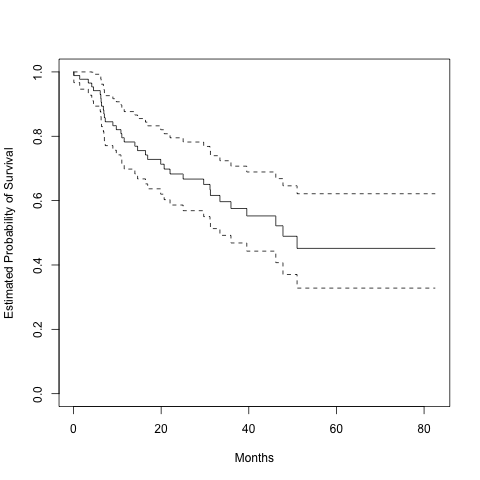

In [11]:
%%R
library(survival)
fit.surv <- survfit(Surv(time, status) ~ 1)
plot(fit.surv, xlab = 'Months',
    ylab = 'Estimated Probability of Survival')

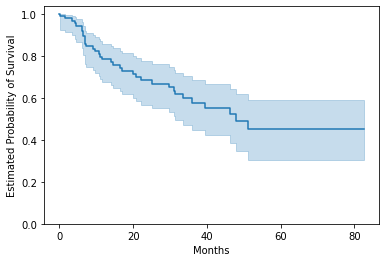

In [12]:
# Using lifelines
kmf_ll = KaplanMeierFitter()
kmf_ll.fit(durations=brain_cancer_df['time'], event_observed=brain_cancer_df['status'])

fig, ax = plt.subplots(1,1)

kmf_ll.plot_survival_function()
plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Estimated Probability of Survival')
ax.get_legend().remove();

#### By Gender

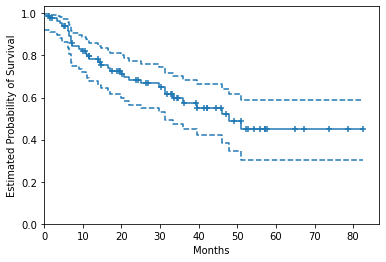

In [13]:
# Using survive
brain_cancer_df['status'] = np.float64(brain_cancer_df['status'])

kmf_surv = survive.KaplanMeier()

surv_data = survive.SurvivalData(time=brain_cancer_df['time'], status=brain_cancer_df['status'])

kmf_surv_fit = kmf_surv.fit(surv_data)

kmf_surv_fit.plot(ci_style='lines')
plt.xlabel('Months')
plt.ylabel('Estimated Probability of Survival');

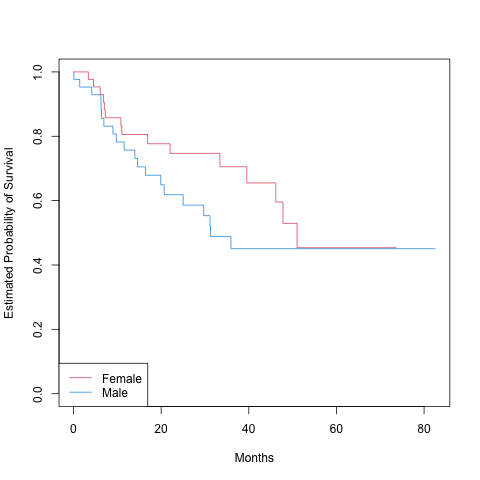

In [14]:
%%R
fit.sex <- survfit(Surv(time, status) ~ sex)
plot(fit.sex, xlab = 'Months',
    ylab = 'Estimated Probability of Survival', col = c(2,4))
legend('bottomleft', levels(sex), col = c(2,4), lty = 1)

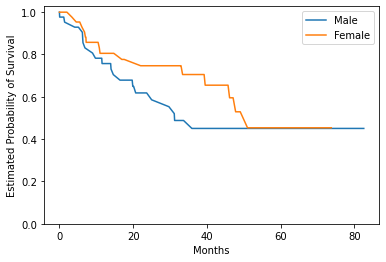

In [15]:
# Using lifelines

fig, ax = plt.subplots(1,1)

male = (brain_cancer_df['sex'] == 'Male')
female = (brain_cancer_df['sex'] == 'Female')

kmf_ll.fit(brain_cancer_df['time'][male], event_observed=brain_cancer_df['status'][male], label='Male')
kmf_ll.survival_function_.plot(ax=ax)

kmf_ll.fit(brain_cancer_df['time'][female], event_observed=brain_cancer_df['status'][female], label='Female')
kmf_ll.survival_function_.plot(ax=ax)

plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Estimated Probability of Survival');

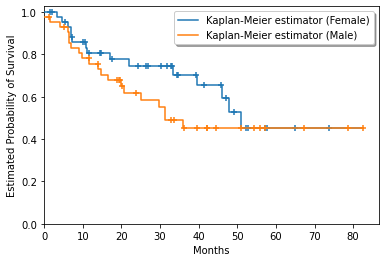

In [16]:
# Using survive

brain_cancer_df['status'] = np.float64(brain_cancer_df['status'])

kmf_surv = survive.KaplanMeier()

surv_data = survive.SurvivalData(time='time', status='status', group='sex', data=brain_cancer_df)

kmf_surv_fit = kmf_surv.fit(surv_data)

fig, ax = plt.subplots(1,1)

kmf_surv.plot(ax=ax, ci=False)

plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Estimated Probability of Survival');

### Log-Rank Test

In [17]:
%%R
logrank.test <- survdiff(Surv(time, status) ~ sex)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ sex)

            N Observed Expected (O-E)^2/E (O-E)^2/V
sex=Female 45       15     18.5     0.676      1.44
sex=Male   43       20     16.5     0.761      1.44

 Chisq= 1.4  on 1 degrees of freedom, p= 0.2 


In [18]:
# Using lifelines

from lifelines.statistics import logrank_test

male = (brain_cancer_df['sex'] == 'Male')
female = (brain_cancer_df['sex'] == 'Female')

results = logrank_test(brain_cancer_df['time'][male], 
                       brain_cancer_df['time'][female],
                       event_observed_A=brain_cancer_df['status'][male],
                       event_observed_B=brain_cancer_df['status'][female]
                      )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [19]:
# Using survive - I don't think it has logrank testing functionality :(

In [20]:
# Using scikit-survival

x = []

for item in zip(brain_cancer_df['status'].astype(bool), brain_cancer_df['time']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

compare_survival(x, brain_cancer_df['sex'], return_stats=True)

(1.440495107079581,
 0.23005923816839605,
         counts  observed   expected  statistic
 group                                         
 Female      45        15  18.539466  -3.539466
 Male        43        20  16.460534   3.539466,
 array([[ 8.69688587, -8.69688587],
        [-8.69688587,  8.69688587]]))

### Cox Proportional Hazards (CoxPH) model

In [21]:
%%R

fit.cox <- coxph(Surv(time, status) ~ sex)
summary(fit.cox)

Call:
coxph(formula = Surv(time, status) ~ sex)

  n= 88, number of events= 35 

          coef exp(coef) se(coef)     z Pr(>|z|)
sexMale 0.4077    1.5033   0.3420 1.192    0.233

        exp(coef) exp(-coef) lower .95 upper .95
sexMale     1.503     0.6652     0.769     2.939

Concordance= 0.565  (se = 0.045 )
Likelihood ratio test= 1.44  on 1 df,   p=0.2
Wald test            = 1.42  on 1 df,   p=0.2
Score (logrank) test = 1.44  on 1 df,   p=0.2



In [22]:
# Using lifelines

cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(brain_cancer_df, 'time', 'status', formula='sex')

In [23]:
cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2023-01-12 02:38:56 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
sex[T.Male]   0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

              cmp to    z    p   -log2(p)
covariate                                
sex[T.Male]     0.00 1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

In [24]:
cph_ll_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [25]:
results.test_statistic, results.degrees_of_freedom, results.p_value

(1.440495107079581, 1, 0.23005923816839605)

In [26]:
# Using survive - I don't think survive can do this

In [27]:
# Using scikit-survival - I don't think there's a nice summary like lifelines has.  I can get the coefficient of the model, the concordance index, but not much else.
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

def gender_to_int(x):
    if x == 'Male':
        return 1
    else:
        return 0


estimator = sksurv.linear_model.CoxPHSurvivalAnalysis(verbose=True).fit(np.array(brain_cancer_df['sex'].apply(gender_to_int)).reshape(-1,1), x)

iter      6: optimization converged


In [28]:
estimator.coef_

array([0.40766854])

In [29]:
# test_df = brain_cancer_df.copy(deep=True)
# test_df['sex'] = test_df['sex'].apply(gender_to_int)



# sksurv.metrics.concordance_index_censored(test_df['status'].astype(bool), test_df['time'], prediction)

In [30]:
%%R
summary(fit.cox)$logtest[1]

    test 
1.438822 


In [31]:
%%R
summary(fit.cox)$waldtest[1]

test 
1.42 


In [32]:
%%R
summary(fit.cox)$sctest[1]

    test 
1.440495 


In [33]:
%%R
logrank.test$chisq

[1] 1.440495


In [34]:
%%R
fit.all <- coxph(
Surv(time, status) ~ sex + diagnosis + loc + ki + gtv + stereo)
fit.all

Call:
coxph(formula = Surv(time, status) ~ sex + diagnosis + loc + 
    ki + gtv + stereo)

                       coef exp(coef) se(coef)      z        p
sexMale             0.18375   1.20171  0.36036  0.510  0.61012
diagnosisLG glioma  0.91502   2.49683  0.63816  1.434  0.15161
diagnosisHG glioma  2.15457   8.62414  0.45052  4.782 1.73e-06
diagnosisOther      0.88570   2.42467  0.65787  1.346  0.17821
locSupratentorial   0.44119   1.55456  0.70367  0.627  0.53066
ki                 -0.05496   0.94653  0.01831 -3.001  0.00269
gtv                 0.03429   1.03489  0.02233  1.536  0.12466
stereoSRT           0.17778   1.19456  0.60158  0.296  0.76760

Likelihood ratio test=41.37  on 8 df, p=1.776e-06
n= 87, number of events= 35 
   (1 observation deleted due to missingness)


In [35]:
brain_cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88 entries, 1 to 88
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int32   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     float64 
 7   time       88 non-null     float64 
dtypes: category(4), float64(3), int32(1)
memory usage: 6.1+ KB


In [36]:
brain_cancer_df[brain_cancer_df['diagnosis'].isnull()==False]

,sex,diagnosis,loc,ki,gtv,stereo,status,time
1,Female,Meningioma,Infratentorial,90,6.11,SRS,0.0,57.64
2,Male,HG glioma,Supratentorial,90,19.35,SRT,1.0,8.98
3,Female,Meningioma,Infratentorial,70,7.95,SRS,0.0,26.46
4,Female,LG glioma,Supratentorial,80,7.61,SRT,1.0,47.80
5,Male,HG glioma,Supratentorial,90,5.06,SRT,1.0,6.30
...,...,...,...,...,...,...,...,...
84,Male,HG glioma,Supratentorial,80,0.16,SRT,1.0,20.69
85,Male,HG glioma,Supratentorial,80,19.81,SRT,1.0,6.39
86,Male,Meningioma,Supratentorial,90,2.50,SRT,0.0,32.82
87,Male,Meningioma,Supratentorial,90,2.02,SRS,0.0,42.07


In [37]:
# Using lifelines

cph_all_ll = CoxPHFitter()
cph_all_ll_fit = cph_ll.fit(brain_cancer_df[brain_cancer_df['diagnosis'].isnull()==False], 'time', 'status', formula='sex + diagnosis + loc + ki + gtv + stereo')

In [38]:
cph_all_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 87
number of events observed = 35
   partial log-likelihood = -116.75
         time fit was run = 2023-01-12 02:38:57 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
diagnosis[T.LG glioma]   0.92       2.50       0.64            -0.34             2.17                 0.71                 8.72
diagnosis[T.HG glioma]   2.15       8.62       0.45             1.27             3.04                 3.57                20.85
diagnosis[T.Other]       0.89       2.42       0.66            -0.40             2.18                 0.67                 8.80
gtv                      0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
ki                      -0.05       0.95       0.02            -0.09            -0.02                 0.91                 0.98
loc[T.Supratentorial]    0.44       1.55       0.70            -0.94             1.82                 0.39                 6.17
sex[T.Male]              0.18       1.20       0.36            -0.52             0.89                 0.59                 2.44
stereo[T.SRT]            0.18       1.19       0.60            -1.00             1.36                 0.37                 3.88

                         cmp to     z      p   -log2(p)
covariate                                              
diagnosis[T.LG glioma]     0.00  1.43   0.15       2.72
diagnosis[T.HG glioma]     0.00  4.78 <0.005      19.14
diagnosis[T.Other]         0.00  1.35   0.18       2.49
gtv                        0.00  1.54   0.12       3.00
ki                         0.00 -3.00 <0.005       8.54
loc[T.Supratentorial]      0.00  0.63   0.53       0.91
sex[T.Male]                0.00  0.51   0.61       0.71
stereo[T.SRT]              0.00  0.30   0.77       0.38
---
Concordance = 0.79
Partial AIC = 249.50
log-likelihood ratio test = 41.37 on 8 df
-log2(p) of ll-ratio test = 19.10

In [39]:
cph_all_ll_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 8
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
          41.37 <0.005     19.10

In [40]:
%%R
modaldata <- data.frame(
    diagnosis = levels(diagnosis),
    sex = rep("Female", 4),
    loc = rep('Supratentorial', 4),
    ki = rep(mean(ki), 4),
    gtv = rep(mean(gtv), 4),
    stereo = rep("SRT", 4)
)

modaldata

   diagnosis    sex            loc       ki      gtv stereo
1 Meningioma Female Supratentorial 81.02273 8.660795    SRT
2  LG glioma Female Supratentorial 81.02273 8.660795    SRT
3  HG glioma Female Supratentorial 81.02273 8.660795    SRT
4      Other Female Supratentorial 81.02273 8.660795    SRT


In [41]:
levels = brain_cancer_df[brain_cancer_df['diagnosis'].isnull()==False]['diagnosis'].unique()[[0,2,1,3]]

# This step is redundant when using lifelines
modal_data_df = pd.DataFrame(data = [levels,
                                     np.repeat("Female", 4),
                                     np.repeat("Supratentorial", 4),
                                     np.repeat(brain_cancer_df['ki'].mean(), 4),
                                     np.repeat(brain_cancer_df['gtv'].mean(), 4),
                                     np.repeat("SRT", 4)],
                                     columns = ['diagnosis', 
                                                'sex', 
                                                'loc', 
                                                'ki', 
                                                'gtv', 
                                                'stereo']
                            )

/var/folders/lp/jgdr2r255gz098q__v2pjv0r0000gn/T/ipykernel_10092/962664037.py:4: FutureWarning: The behavior of DataFrame([categorical, ...]) is deprecated and in a future version will be changed to match the behavior of DataFrame([any_listlike, ...]). To retain the old behavior, pass as a dictionary DataFrame({col: categorical, ..})
  modal_data_df = pd.DataFrame(data = [levels,


In [42]:
modal_data_df

,diagnosis,sex,loc,ki,gtv,stereo
0,Meningioma,Female,Supratentorial,81.022727,8.660795,SRT
1,LG glioma,Female,Supratentorial,81.022727,8.660795,SRT
2,HG glioma,Female,Supratentorial,81.022727,8.660795,SRT
3,Other,Female,Supratentorial,81.022727,8.660795,SRT


#### Survival Curve by Diagnosis

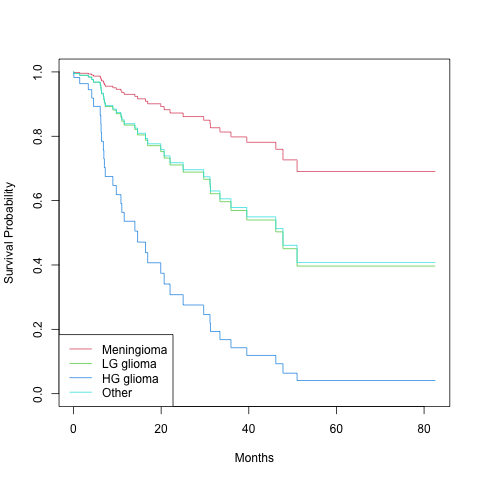

In [43]:
%%R
survplots <- survfit(fit.all, newdata = modaldata)
plot(survplots, xlab = 'Months',
    ylab = 'Survival Probability', col = 2:5)
legend('bottomleft', levels(diagnosis), col = 2:5, lty = 1)

In [102]:
%%R
survplots

Call: survfit(formula = fit.all, newdata = modaldata)

   n events median 0.95LCL 0.95UCL
1 87     35     NA      NA      NA
2 87     35   47.8   22.03      NA
3 87     35   14.6    7.25    46.2
4 87     35   47.8   22.03      NA


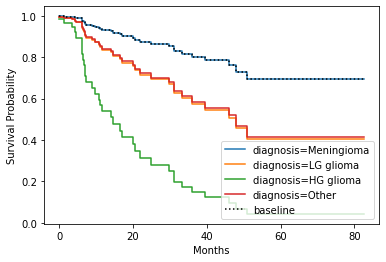

In [45]:
# Using lifelines

cph_all_ll_fit.plot_partial_effects_on_outcome('diagnosis', levels)
plt.xlabel('Months')
plt.ylabel('Survival Probability');

In [46]:
# # Using lifelines
# new_df = brain_cancer_df.dropna()

# fig, ax = plt.subplots(1,1)

# for level in levels:
#     idx = (new_df['diagnosis'] == level)
    

#     cph_all_ll_fit = cph_all_ll.fit(df = new_df.dropna()[idx],
#                                     duration_col = 'time',
#                                     event_col = 'status',
#                                     formula='sex + loc + ki + gtv + stereo',
#                                     show_progress = True)
#     cph_all_ll_fit.survival_function_.plot(ax=ax)

# plt.xlabel('Months')
# plt.yticks(np.arange(0, 1.1, 0.2))
# plt.ylabel('Survival Probability');

## 11.8.2 Publication Data

### Kaplan Meier Survival Curve by posres

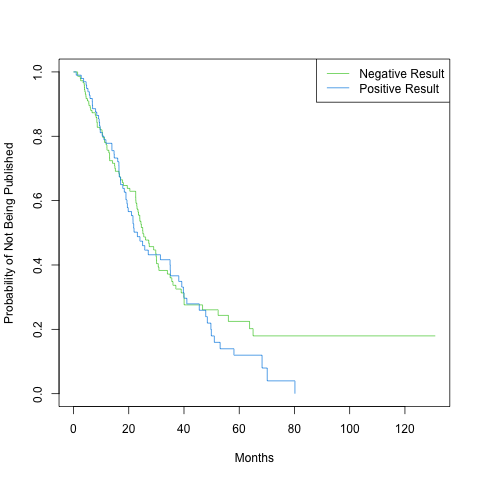

In [47]:
%%R
fit.posres <- survfit(
    Surv(time,  status) ~ posres, data = Publication
)
plot(fit.posres, xlab='Months',
    ylab = 'Probability of Not Being Published', col = 3:4)
legend("topright", c("Negative Result", "Positive Result"),
      col = 3:4, lty = 1)

In [48]:
data = robjects.r("""
library(ISLR2)
xdata <- Publication
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    publication_df = robjects.conversion.rpy2py(data)

In [49]:
publication_df.head()

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
1,0,0,1,R01,39876,8.016941,44.016,11.203285,1
2,0,0,1,R01,39876,8.016941,23.494,15.178645,1
3,0,0,1,R01,8171,7.612606,8.391,24.410678,1
4,0,0,1,Contract,24335,11.771928,15.402,2.595483,1
5,0,0,1,Contract,33357,76.517537,16.783,8.607803,1


In [50]:
publication_df['posres'].unique()

array([0, 1], dtype=int32)

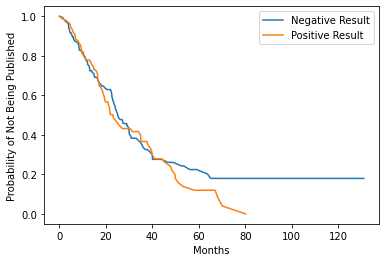

In [51]:
# Using lifelines

fig, ax = plt.subplots(1,1)

for level in publication_df['posres'].unique():

    idx = (publication_df['posres'] == level)

    if level == 1:
        label = "Positive Result"
    else:
        label = "Negative Result"
        
    kmf_ll.fit(publication_df['time'][idx], 
               event_observed=publication_df['status'][idx], 
               label=label)
    kmf_ll.survival_function_.plot(ax=ax)


plt.xlabel('Months')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Not Being Published');

### CoxPH by posres

In [52]:
%%R
fit.pub <- coxph(Surv(time, status) ~ posres,
                data = Publication)
fit.pub

Call:
coxph(formula = Surv(time, status) ~ posres, data = Publication)

         coef exp(coef) se(coef)     z    p
posres 0.1481    1.1596   0.1616 0.916 0.36

Likelihood ratio test=0.83  on 1 df, p=0.3611
n= 244, number of events= 156 


In [53]:
# Using lifelines

cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(publication_df, 'time', 'status', formula='posres')

In [54]:
cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -723.47
         time fit was run = 2023-01-12 02:38:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.15       1.16       0.16            -0.17             0.46                 0.84                 1.59

            cmp to    z    p   -log2(p)
covariate                              
posres        0.00 0.92 0.36       1.48
---
Concordance = 0.50
Partial AIC = 1448.95
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

In [55]:
%%R
logrank.test <- survdiff(Surv(time, status) ~ posres,
                        data = Publication)
logrank.test

Call:
survdiff(formula = Surv(time, status) ~ posres, data = Publication)

           N Observed Expected (O-E)^2/E (O-E)^2/V
posres=0 146       87     92.6     0.341     0.844
posres=1  98       69     63.4     0.498     0.844

 Chisq= 0.8  on 1 degrees of freedom, p= 0.4 


In [56]:
# Using lifelines

from lifelines.statistics import logrank_test

neg = (publication_df['posres'] == 0)
pos = (publication_df['posres'] == 1)

results = logrank_test(publication_df['time'][neg], 
                       publication_df['time'][pos],
                       event_observed_A=publication_df['status'][neg],
                       event_observed_B=publication_df['status'][pos]
                      )

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.84 0.36      1.48

In [57]:
# Using scikit-survival

x = []

for item in zip(publication_df['status'].astype(bool), publication_df['time']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

compare_survival(x, publication_df['posres'], return_stats=True)

/Users/rancher/opt/anaconda3/envs/ox/lib/python3.9/site-packages/sksurv/compare.py:115: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  table.index = pandas.Index(groups, name="group")


(0.8439998569292538,
 0.35825530980101306,
        counts  observed  expected  statistic
 group                                       
 0         146        87  92.61852   -5.61852
 1          98        69  63.38148    5.61852,
 array([[ 37.4025698, -37.4025698],
        [-37.4025698,  37.4025698]]))

In [58]:
%%R
fit.pub2 <- coxph(Surv(time, status) ~ . - mech,
                 data = Publication)
fit.pub2

Call:
coxph(formula = Surv(time, status) ~ . - mech, data = Publication)

               coef  exp(coef)   se(coef)      z       p
posres    5.708e-01  1.770e+00  1.760e-01  3.244 0.00118
multi    -4.086e-02  9.600e-01  2.512e-01 -0.163 0.87079
clinend   5.462e-01  1.727e+00  2.620e-01  2.085 0.03710
sampsize  4.678e-06  1.000e+00  1.472e-05  0.318 0.75070
budget    4.385e-03  1.004e+00  2.465e-03  1.779 0.07518
impact    5.832e-02  1.060e+00  6.676e-03  8.735 < 2e-16

Likelihood ratio test=149.2  on 6 df, p=< 2.2e-16
n= 244, number of events= 156 


In [59]:
def formula_from_cols(df, y, use_target, remove_intercept):
    formula_string = ' + '.join([col for col in df.columns if not col==y])
    if use_target == True:
        formula_string = y + ' ~ ' + formula_string
    if remove_intercept == True:
        formula_string = formula_string + ' - 1'
    return formula_string

In [60]:
formula_string = formula_from_cols(publication_df, 'mech', False, False)

In [61]:
formula_string

'posres + multi + clinend + sampsize + budget + impact + time + status'

In [62]:
# Using lifelines

cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(publication_df, 'time', 'status', formula='posres + multi + clinend + sampsize + budget + impact')

In [63]:
cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -649.26
         time fit was run = 2023-01-12 02:38:58 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
budget      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
clinend     0.55       1.73       0.26             0.03             1.06                 1.03                 2.89
impact      0.06       1.06       0.01             0.05             0.07                 1.05                 1.07
multi      -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.57
posres      0.57       1.77       0.18             0.23             0.92                 1.25                 2.50
sampsize    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

            cmp to     z      p   -log2(p)
covariate                                 
budget        0.00  1.78   0.08       3.73
clinend       0.00  2.08   0.04       4.75
impact        0.00  8.74 <0.005      58.52
multi         0.00 -0.16   0.87       0.20
posres        0.00  3.24 <0.005       9.73
sampsize      0.00  0.32   0.75       0.41
---
Concordance = 0.80
Partial AIC = 1310.53
log-likelihood ratio test = 149.25 on 6 df
-log2(p) of ll-ratio test = 96.18

## 11.8.3 Call Center Data

In [64]:
%%R
set.seed(4)
N <- 2000
Operators <- sample(5:15, N, replace = T)
Center <- sample(c("A", "B", "C"), N, replace = T)
Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
X <- model.matrix( ~ Operators + Center + Time)[, -1]

In [65]:
%%R
X[1:5, ]

  Operators CenterB CenterC TimeEven. TimeMorn.
1        12       1       0         0         1
2        15       0       0         0         0
3         7       0       1         1         0
4         7       0       0         0         0
5        11       0       1         0         1


In [66]:
# r_data = robjects.r("""
# set.seed(4)
# N <- 2000
# Operators <- sample(5:15, N, replace = T)
# Center <- sample(c("A", "B", "C"), N, replace = T)
# Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
# X_df = data.frame(Operators, Center, Time)
# """)

# with localconverter(robjects.default_converter + pandas2ri.converter):
#     call_center_df = robjects.conversion.rpy2py(r_data)

In [67]:
# X_dmatrix = patsy.dmatrix(formula_like = 'Operators + Center + Time', data = call_center_df)

In [68]:
# X_dmatrix[0:5, 1:]

In [69]:
%%R
true.beta <- c(0.04, -0.3, 0, 0.2, -0.2)
h.fn <- function(x) return(0.00001 * x)

In [70]:
# true_beta = np.array([0.04, -0.3, 0, 0.2, -0.2])

# def h_fn(x):
#     return 0.00001 * x

In [71]:
%%R
library(coxed)

R[write to console]: Loading required package: rms

R[write to console]: Loading required package: Hmisc

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: Formula

R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘Hmisc’


R[write to console]: The following objects are masked from ‘package:base’:

    format.pval, units


R[write to console]: Loading required package: SparseM

R[write to console]: 
Attaching package: ‘SparseM’


R[write to console]: The following object is masked from ‘package:base’:

    backsolve


R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



In [72]:
%%R
set.seed(4)
N <- 2000
Operators <- sample(5:15, N, replace = T)
Center <- sample(c("A", "B", "C"), N, replace = T)
Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
X <- model.matrix( ~ Operators + Center + Time)[, -1]

queuing <- sim.survdata(N = N, T = 1000, X = X,
beta = true.beta, hazard.fun = h.fn)

names(queuing)

[1] "data"             "xdata"            "baseline"         "xb"              
[5] "exp.xb"           "betas"            "ind.survive"      "marg.effect"     
[9] "marg.effect.data"


In [73]:
r_data = robjects.r("""
queuing_data <- queuing$data
""")

with localconverter(robjects.default_converter + pandas2ri.converter):
    queuing_df = robjects.conversion.rpy2py(r_data)

In [74]:
%%R
head(queuing$data)

  Operators CenterB CenterC TimeEven. TimeMorn.   y failed
1        12       1       0         0         1 344   TRUE
2        15       0       0         0         0 241   TRUE
3         7       0       1         1         0 187   TRUE
4         7       0       0         0         0 279   TRUE
5        11       0       1         0         1 954   TRUE
6         7       1       0         0         1 455   TRUE


In [75]:
queuing_df.head()

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.,y,failed
1,12.0,1.0,0.0,0.0,1.0,344,True
2,15.0,0.0,0.0,0.0,0.0,241,True
3,7.0,0.0,1.0,1.0,0.0,187,True
4,7.0,0.0,0.0,0.0,0.0,279,True
5,11.0,0.0,1.0,0.0,1.0,954,True


In [76]:
%%R
mean(queuing$data$failed)

[1] 0.89


In [77]:
queuing_df['failed'].mean()

0.89

In [78]:
%%R
par(mfrow = c(1,2))
fit.Center <- survfit(Surv(y, failed) ~ Center,
                      data = queuing$data)

In [79]:
# Using lifelines

center_b_idx = (queuing_df['CenterB'] == 1)
center_c_idx = (queuing_df['CenterC'] == 1)
center_a_idx = (~(center_b_idx) & ~(center_c_idx))

kmf_ll_a = KaplanMeierFitter(label='Call Center A')
kmf_ll_a.fit(durations=queuing_df['y'][center_a_idx], 
             event_observed=queuing_df['failed'][center_a_idx])

kmf_ll_b = KaplanMeierFitter(label='Call Center B')
kmf_ll_b.fit(durations=queuing_df['y'][center_b_idx], 
             event_observed=queuing_df['failed'][center_b_idx])

kmf_ll_c = KaplanMeierFitter(label='Call Center C')
kmf_ll_c.fit(durations=queuing_df['y'][center_c_idx],
             event_observed=queuing_df['failed'][center_c_idx])

<lifelines.KaplanMeierFitter:"Call Center C", fitted with 650 total observations, 73 right-censored observations>

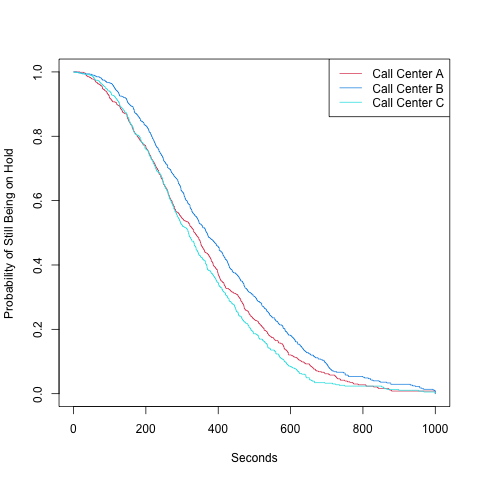

In [80]:
%%R
plot(fit.Center, xlab = 'Seconds',
    ylab = 'Probability of Still Being on Hold',
    col = c(2, 4, 5))
legend("topright",
      c("Call Center A", "Call Center B", "Call Center C"),
      col = c(2, 4, 5), lty = 1)

In [81]:
queuing_df.head()

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.,y,failed
1,12.0,1.0,0.0,0.0,1.0,344,True
2,15.0,0.0,0.0,0.0,0.0,241,True
3,7.0,0.0,1.0,1.0,0.0,187,True
4,7.0,0.0,0.0,0.0,0.0,279,True
5,11.0,0.0,1.0,0.0,1.0,954,True


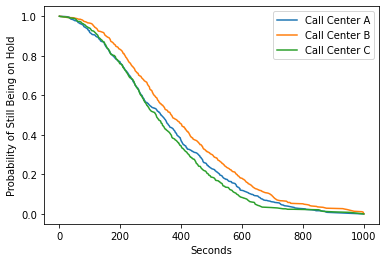

In [82]:
fig, ax = plt.subplots(1,1)

kmf_ll_a.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')

kmf_ll_b.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')


kmf_ll_c.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold');

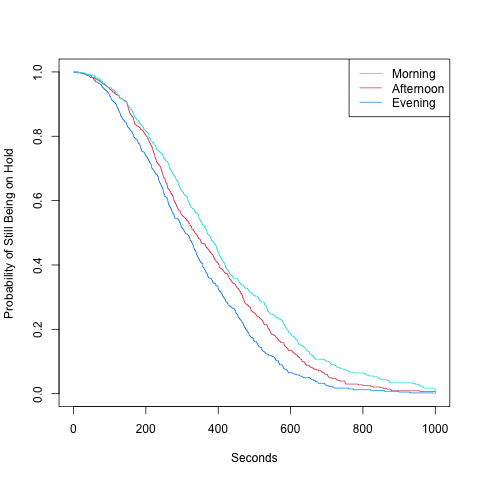

In [83]:
%%R
fit.Time <- survfit(Surv(y, failed) ~ Time,
                    data = queuing$data)
plot(fit.Time, xlab = "Seconds",
    ylab = 'Probability of Still Being on Hold',
    col = c(2, 4, 5))
legend("topright", c("Morning", "Afternoon", "Evening"),
      col = c(5, 2, 4), lty = 1)

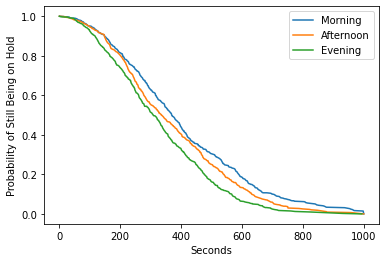

In [84]:
# Using lifelines

time_morn_idx = (queuing_df['TimeMorn.'] == 1)
time_even_idx = (queuing_df['TimeEven.'] == 1)
time_after_idx = (~(time_morn_idx) & ~(time_even_idx))

kmf_ll_morn = KaplanMeierFitter(label='Morning')
kmf_ll_morn.fit(durations=queuing_df['y'][time_morn_idx], 
             event_observed=queuing_df['failed'][time_morn_idx])

kmf_ll_after = KaplanMeierFitter(label='Afternoon')
kmf_ll_after.fit(durations=queuing_df['y'][time_after_idx], 
             event_observed=queuing_df['failed'][time_after_idx])

kmf_ll_even = KaplanMeierFitter(label='Evening')
kmf_ll_even.fit(durations=queuing_df['y'][time_even_idx],
             event_observed=queuing_df['failed'][time_even_idx])

fig, ax = plt.subplots(1,1)

kmf_ll_morn.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')

kmf_ll_after.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold')


kmf_ll_even.survival_function_.plot(ax=ax)
plt.xlabel('Seconds')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.ylabel('Probability of Still Being on Hold');

In [85]:
%%R
survdiff(Surv(y, failed) ~ Center, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Center, data = queuing$data)

           N Observed Expected (O-E)^2/E (O-E)^2/V
Center=A 683      603      579     0.971      1.45
Center=B 667      600      701    14.641     24.64
Center=C 650      577      499    12.062     17.05

 Chisq= 28.3  on 2 degrees of freedom, p= 7e-07 


In [86]:
r_data = robjects.r("""
center_data <- Center
""")

with localconverter(robjects.default_converter + pandas2ri.converter):
    centers = robjects.conversion.rpy2py(r_data)
    
centers = np.array(centers)

In [87]:
# Using scikit-survival

x = []

for item in zip(queuing_df['failed'].astype(bool), queuing_df['y']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

compare_survival(x, centers, return_stats=True)

(28.260500688250694,
 7.299788001432358e-07,
        counts  observed    expected   statistic
 group                                          
 A         683       603  579.281031   23.718969
 B         667       600  701.330745 -101.330745
 C         650       577  499.388224   77.611776,
 array([[ 386.70733443, -225.05249618, -161.65483824],
        [-225.05249618,  416.77070782, -191.71821164],
        [-161.65483824, -191.71821164,  353.37304988]]))

In [88]:
%%R
survdiff(Surv(y, failed) ~ Time, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Time, data = queuing$data)

              N Observed Expected (O-E)^2/E (O-E)^2/V
Time=After. 688      616      619    0.0135     0.021
Time=Even.  653      582      468   27.6353    38.353
Time=Morn.  659      582      693   17.7381    29.893

 Chisq= 46.8  on 2 degrees of freedom, p= 7e-11 


In [89]:
r_data = robjects.r("""
time_data <- Time
""")

with localconverter(robjects.default_converter + pandas2ri.converter):
    times = robjects.conversion.rpy2py(r_data)
    
times = np.array(times)

In [90]:
# Using scikit-survival

x = []

for item in zip(queuing_df['failed'].astype(bool), queuing_df['y']):
    x.append(item)

x = np.array(x, dtype='bool,f').flatten()

compare_survival(x, times, return_stats=True)

(46.786509835574705,
 6.925298148953775e-11,
         counts  observed    expected   statistic
 group                                           
 After.     688       616  618.894245   -2.894245
 Even.      653       582  468.245400  113.754600
 Morn.      659       582  692.860355 -110.860355,
 array([[ 399.50031207, -162.87881743, -236.62149463],
        [-162.87881743,  337.39771067, -174.51889324],
        [-236.62149463, -174.51889324,  411.14038787]]))

In [91]:
%%R
fit.queuing <- coxph(Surv(y, failed) ~ .,
                    data = queuing$data)
fit.queuing

Call:
coxph(formula = Surv(y, failed) ~ ., data = queuing$data)

              coef exp(coef) se(coef)      z        p
Operators  0.04174   1.04263  0.00759  5.500  3.8e-08
CenterB   -0.21879   0.80349  0.05793 -3.777 0.000159
CenterC    0.07930   1.08253  0.05850  1.356 0.175256
TimeEven.  0.20904   1.23249  0.05820  3.592 0.000328
TimeMorn. -0.17352   0.84070  0.05811 -2.986 0.002828

Likelihood ratio test=102.8  on 5 df, p=< 2.2e-16
n= 2000, number of events= 1780 


In [92]:
queuing_df

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.,y,failed
1,12.0,1.0,0.0,0.0,1.0,344,True
2,15.0,0.0,0.0,0.0,0.0,241,True
3,7.0,0.0,1.0,1.0,0.0,187,True
4,7.0,0.0,0.0,0.0,0.0,279,True
5,11.0,0.0,1.0,0.0,1.0,954,True
...,...,...,...,...,...,...,...
1996,11.0,0.0,0.0,0.0,1.0,398,True
1997,5.0,0.0,1.0,1.0,0.0,427,True
1998,13.0,0.0,1.0,0.0,0.0,412,True
1999,14.0,0.0,1.0,0.0,0.0,153,True


In [93]:
r_data = robjects.r("""
operator_data <- Operators
""")

with localconverter(robjects.default_converter + pandas2ri.converter):
    operators = robjects.conversion.rpy2py(r_data)
    
operators = np.array(operators)

In [94]:
operators.reshape(-1,1).shape

(2000, 1)

In [95]:
y = np.array(queuing_df['y'])
failed = np.array(queuing_df['failed'])

un_1h_df = pd.DataFrame(data={"Operators":operators, "Center":centers, "Time":times, "y": y, "failed":failed})

In [96]:
un_1h_df

,Operators,Center,Time,y,failed
0,12,B,Morn.,344,True
1,15,A,After.,241,True
2,7,C,Even.,187,True
3,7,A,After.,279,True
4,11,C,Morn.,954,True
...,...,...,...,...,...
1995,11,A,Morn.,398,True
1996,5,C,Even.,427,True
1997,13,C,After.,412,True
1998,14,C,After.,153,True


In [97]:
# Using lifelines

cph_ll = CoxPHFitter()
cph_ll_fit = cph_ll.fit(un_1h_df, 'y', 'failed', formula='Operators + Center + Time')

In [98]:
cph_ll_fit.print_summary()

<lifelines.CoxPHFitter: fitted with 2000 total observations, 220 right-censored observations>
             duration col = 'y'
                event col = 'failed'
      baseline estimation = breslow
   number of observations = 2000
number of events observed = 1780
   partial log-likelihood = -11699.73
         time fit was run = 2023-01-12 02:39:03 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Center[T.B]    -0.22       0.80       0.06            -0.33            -0.11                 0.72                 0.90
Center[T.C]     0.08       1.08       0.06            -0.04             0.19                 0.97                 1.21
Operators       0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
Time[T.Even.]   0.21       1.23       0.06             0.09             0.32                 1.10                 1.38
Time[T.Morn.]  -0.17       0.84       0.06            -0.29            -0.06                 0.75                 0.94

                cmp to     z      p   -log2(p)
covariate                                     
Center[T.B]       0.00 -3.78 <0.005      12.62
Center[T.C]       0.00  1.36   0.18       2.51
Operators         0.00  5.50 <0.005      24.65
Time[T.Even.]     0.00  3.59 <0.005      11.57
Time[T.Morn.]     0.00 -2.99 <0.005       8.47
---
Concordance = 0.57
Partial AIC = 23409.45
log-likelihood ratio test = 102.81 on 5 df
-log2(p) of ll-ratio test = 66.00

The End